Pricing FX options via Heston 
==

This notebook will reproduce the pricing results from STF2hes03.m an appendix to ['FX Smile in the Heston Model'](https://arxiv.org/abs/1010.1617).
Heston pricing does not have a analytical solution. The following numerical methods are available:
1. Original 1993 Heston algorithm integrated with adaptive Gauss-Kronrod quadrature
2. Carr-Madan approach integrated with adaptive Gauss-Kronrod quadrature
3. Fast Fourier Transform 
4. Lipton approach integrated with adaptive Gauss-Kronrod quadrature
5. COS method (recommended)

Citation:
Janek, Agnieszka & Kluge, Tino & Weron, Rafał & Wystup, Uwe. (2010). FX Smile in the Heston Model. Statistical Tools for Finance and Insurance. 10.48550/arXiv.1010.1617. 

In [1]:
# -*- coding: utf-8 -*-
import os

if __name__ == "__main__":
    os.chdir(os.environ.get('PROJECT_DIR_FRM'))

import numpy as np
import matplotlib.pyplot as plt
from time import time

from frm.pricing_engine.heston import \
    heston_carr_madan_price_vanilla_european, \
    heston_cosine_price_vanilla_european, \
    heston1993_price_vanilla_european, \
    heston_lipton_price_vanilla_european

The following data is copied from the MATLAB file 'STF2hes03.m'.  

There have been minor changes to variable names and quoting convetions.

The file was retrieved from [https://ideas.repec.org/c/wuu/hscode/zip10001.html](https://ideas.repec.org/c/wuu/hscode/zip10001.html). The webpage has also been saved to [WaybackMachine](https://web.archive.org/web/20240926111306/https://ideas.repec.org/c/wuu/hscode/zip10001.html)


In [2]:
# Inputs copied from STF2hes03.m which is a support to
# "FX smile in the Heston model" by A Janek, 2010.
# Source: https://ideas.repec.org/c/wuu/hscode/zip10001.html
# WaybackMachine save: 
# https://web.archive.org/web/20240926111306/https://ideas.repec.org/c/wuu/hscode/zip10001.html

S0 = 1.2 # Initial spot price
tau = 0.5 # Time to expiry
r_d = 0.022 # Domestic interest rate, continuously compounded
r_f = 0.018 # Foreign interest rate, continuously compounded
var0 = 0.01 # Initial variance
vv = 0.2 # Volatility of volatility
kappa = 1.5 # Mean reversion speed to long-run variance
theta = 0.015 # Long run variance
rho = 0.05 # Correlation between the asset and its variance
lambda_ = 0 # Risk premium (set to zero as we are calibrating to market prices not historical data)

K = np.linspace(1.1,1.3,81)

# Tolerances
dp = 7
tol = 1 / (10**dp)

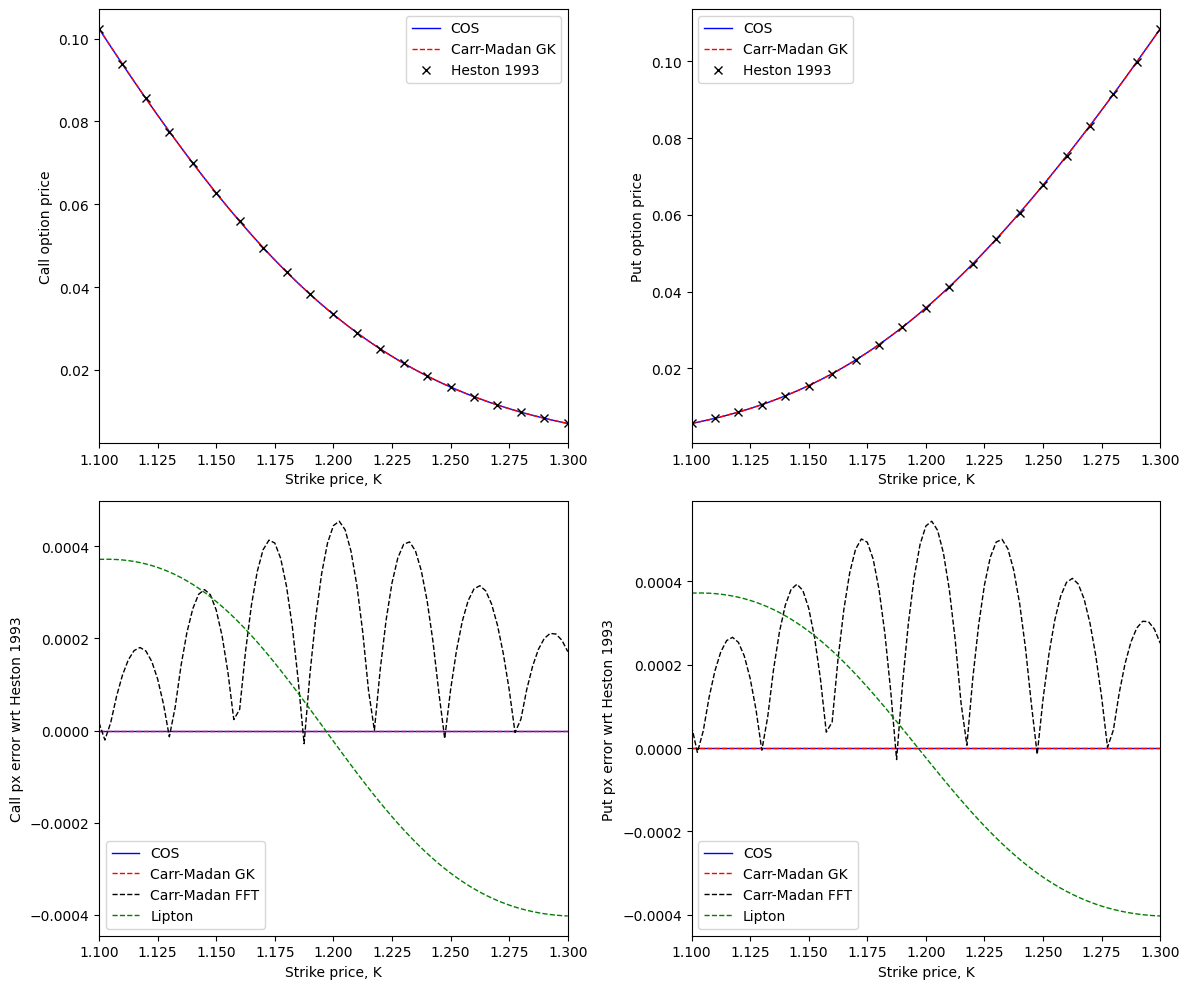

In [3]:
# The COS method is can be applied to multiple strikes (i.e. it is vectorised to multiple strikes)
cp = np.ones(shape=K.shape) 
COS_call = heston_cosine_price_vanilla_european(S0, tau, r_f, r_d, cp, K, var0, vv, kappa, theta, rho, N=160, L=10)
cp = -1 * cp
COS_put = heston_cosine_price_vanilla_european(S0, tau, r_f, r_d, cp, K, var0, vv, kappa, theta, rho, N=160, L=10)


# The other pricing methods require a scalar strike due to the limitations of the underlying numerical integration algorithms.
heston_1993_call, heston_1993_put = np.empty(K.shape), np.empty(K.shape)
cm_quad_call, cm_quad_put = np.empty(K.shape), np.empty(K.shape)
cm_fft_call, cm_fft_put = np.empty(K.shape), np.empty(K.shape)
lipton_call, lipton_put = np.empty(K.shape), np.empty(K.shape)

for i in range(len(K)):

        # Call options
        cp_ = 1
        heston_1993_call[i] = heston1993_price_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, lambda_)
        cm_quad_call[i] = heston_carr_madan_price_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, integration_method=0)
        cm_fft_call[i] = heston_carr_madan_price_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, integration_method=1)
        lipton_call[i] = heston_lipton_price_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho)
        # COS_call[i] = heston_cosine_price_vanilla_european(S0, tau, r_f, r_d, cp, K[i], var0, vv, kappa, theta, rho, N=160, L=10)
         
        # Put options
        cp_ = -1
        heston_1993_put[i] = heston1993_price_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, lambda_)
        cm_quad_put[i] = heston_carr_madan_price_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, integration_method=0)
        cm_fft_put[i] = heston_carr_madan_price_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, integration_method=1)
        lipton_put[i] = heston_lipton_price_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho)
        # COS_put[i] = heston_cosine_price_fx_vanilla_european(S0, tau, r_f, r_d, cp, K[i], var0, vv, kappa, theta, rho, N=160, L=10)        
        

# Calculate errors with respect to the Heston 1993 algorithm
error_COS_call = COS_call - heston_1993_call
error_cm_quad_call = cm_quad_call - heston_1993_call
error_cm_fft_call = cm_fft_call - heston_1993_call
error_lipton_call = lipton_call - heston_1993_call

error_COS_put = COS_put - heston_1993_put
error_cm_quad_put = cm_quad_put - heston_1993_put
error_cm_fft_put = cm_fft_put - heston_1993_put
error_lipton_put = lipton_put - heston_1993_put

# These plot's match those STF2hes03.m, with the addition of the COS method, to demonstrate the accuracy of the COS method.
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# First subplot
axs[0, 0].plot(K, COS_call, 'b-', linewidth=1)
axs[0, 0].plot(K, cm_quad_call, 'r--', linewidth=1)
axs[0, 0].plot(K[::4], heston_1993_call[::4], 'kx', linewidth=1)
axs[0, 0].set_xlabel('Strike price, K')
axs[0, 0].set_ylabel('Call option price')
axs[0, 0].legend(['COS', 'Carr-Madan GK', 'Heston 1993'], loc='upper right')
axs[0, 0].set_xlim(min(K), max(K))

# Second subplot
axs[0, 1].plot(K, COS_put, 'b-', linewidth=1)
axs[0, 1].plot(K, cm_quad_put, 'r--', linewidth=1)
axs[0, 1].plot(K[::4], heston_1993_put[::4], 'kx', linewidth=1)
axs[0, 1].set_xlabel('Strike price, K')
axs[0, 1].set_ylabel('Put option price')
axs[0, 1].legend(['COS', 'Carr-Madan GK', 'Heston 1993'], loc='upper left')
axs[0, 1].set_xlim(min(K), max(K))

# Third subplot
axs[1, 0].plot(K, error_COS_call, 'b-', linewidth=1)
axs[1, 0].plot(K, error_cm_quad_call, 'r--', linewidth=1)
axs[1, 0].plot(K, error_cm_fft_call, 'k--', linewidth=1)
axs[1, 0].plot(K, error_lipton_call, 'g--', linewidth=1)
axs[1, 0].set_xlabel('Strike price, K')
axs[1, 0].set_ylabel('Call px error wrt Heston 1993')
axs[1, 0].legend(['COS', 'Carr-Madan GK', 'Carr-Madan FFT','Lipton'], loc='lower left')
axs[1, 0].set_xlim(min(K), max(K))

# Fourth subplot
axs[1, 1].plot(K, error_COS_put, 'b-', linewidth=1)
axs[1, 1].plot(K, error_cm_quad_put, 'r--', linewidth=1)
axs[1, 1].plot(K, error_cm_fft_put, 'k--', linewidth=1)
axs[1, 1].plot(K, error_lipton_put, 'g--', linewidth=1)
axs[1, 1].set_xlabel('Strike price, K')
axs[1, 1].set_ylabel('Put px error wrt Heston 1993')
axs[1, 1].legend(['COS', 'Carr-Madan GK', 'Carr-Madan FFT','Lipton'], loc='lower left')
axs[1, 1].set_xlim(min(K), max(K))

plt.tight_layout()
plt.show()

Per the prior chart,
1. the original 1993 Heston algorithm (with adaptive Gauss-Kronrod quadrature)
2. the Carr-Madan approach with adaptive Gauss-Kronrod quadrature, and
3. the COS method,
all produce highly accurate results.

The Lipton approach and the Carr-Madan approach with fast fourier transform are less accurate, but still within acceptable bounds.

Let's inspect the runtime of the methods.

In [4]:
print('Runtime of various Heston pricing methods:')

nb_runs = 100

t1 = time()
for i in range(nb_runs):
    heston_cosine_price_vanilla_european(S0, tau, r_f, r_d, cp, K, var0, vv, kappa, theta, rho, N=160, L=10)
t2 = time()
print("COS method: ", round(t2-t1,3))

t1 = time()
for j in range(nb_runs):
    for i in range(len(K)):
        heston_carr_madan_price_vanilla_european(S0, tau, r_f, r_d, 1, K[i], var0, vv, kappa, theta, rho, integration_method=0)
t2 = time()
print("Carr-Madan GK: ", round(t2-t1,3))

t1 = time()
for j in range(nb_runs):
    for i in range(len(K)):
        heston_carr_madan_price_vanilla_european(S0, tau, r_f, r_d, 1, K[i], var0, vv, kappa, theta, rho, integration_method=1)
t2 = time()
print("Carr-Madan FFT: ", round(t2-t1,3))

t1 = time()
for j in range(nb_runs):
    for i in range(len(K)):
        heston_lipton_price_vanilla_european(S0, tau, r_f, r_d, 1, K[i], var0, vv, kappa, theta, rho)
t2 = time()
print("Lipton: ", round(t2-t1,3))

t1 = time()
for j in range(nb_runs):
    for i in range(len(K)):
        heston1993_price_vanilla_european(S0, tau, r_f, r_d, 1, K[i], var0, vv, kappa, theta, rho)
t2 = time()
print("Heston 1993: ", round(t2-t1,3))

Runtime of various Heston pricing methods:
COS method:  0.149
Carr-Madan GK:  1.071
Carr-Madan FFT:  3.146
Lipton:  1.698
Heston 1993:  7.265


Overall COS method is the most accurate and the fastest. It's key downside was the complexity in implementation.
Hence, it is the recommended method for calculating the heston model to a smile of vanilla options prices.

If performance is not a concern the Carr-Madan approach with adaptive Gauss-Kronrod quadrature and the original 1993 Heston algorithm are accurate methods.

The Lipton approach and the Carr-Madan approach with fast fourier transform are less accurate and slower, and hence not recommended as the pricing method.